In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

from glob import glob


def cell_attributes():
    import yaml

    with open("../configs/prw/grid_id0/cell0.yaml") as f:
        configs = yaml.safe_load(f)
    D = configs["D"]
    alpha = configs["alpha"]
    return D, alpha


def plot_distributions(cms):
    from substrate.substrates import Substrate

    sub_generator = Substrate(N_mesh=200, L_box=50)
    chi = sub_generator.two_state_sub()

    fig = plt.figure(figsize=(5, 5))

    ax = plt.subplot2grid((3, 3), (1, 0), rowspan=2)
    ax.hist(cms.y.values, color="blue", orientation="horizontal")
    ax.set_ylim([0, 50])
    ax.set_xlabel("PDF(y)")
    ax.set_ylabel("y")

    ax = plt.subplot2grid((3, 3), (0, 1), colspan=2)
    ax.hist(cms.x.values, color="red")
    ax.set_xlim([0, 50])
    ax.set_xlabel("x")
    ax.set_ylabel("PDF(x)")

    ax = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)
    ax.scatter(cms.x, cms.y, c=range(cms.shape[0]), cmap="viridis")
    ax.contour(
        chi, levels=[0.5], colors=["black"], linewidths=[3], extent=[0, 50, 0, 50]
    )
    import matplotlib as mplt

    times = cms["time[hr]"].values
    norm = mplt.colors.Normalize(vmin=times[0], vmax=times[-1] / 24)
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap="viridis"), location="bottom", pad=-0.2
    )
    cbar.set_label("Days")
    ax.axis("off")


def hist_hopping_time(cms):
    # cms["bin"] = [0 if np.fabs(x-12.5)<2.5 else 1 for x in cms.x.values]

    # index one after which the cell has hopped
    hopped_indx = np.where(np.diff(cms.bin.values) != 0)[0]
    cum_time_before_hop = np.diff(cms.iloc[hopped_indx]["time[hr]"].values, prepend=0)
    return cum_time_before_hop


def read_all_files(pathname_fmt, n_workers):
    files = glob(pathname_fmt)
    with Pool(processes=n_workers) as p:
        res = p.map_async(_read_file, files)
        p.close()
        p.join()

    res = res.get(timeout=1)
    return pd.concat(res).reset_index(drop=True)


def _read_file(file):
    df = pd.read_csv(file).drop(columns=["Unnamed: 0"])
    df["time[hr]"] = df.index * 2000 * 0.002 * 8 / 60
    return df


def _calc_v(x, dt):
    # x is in mu
    # dt is in hr
    return np.diff(x) / dt


def _calc_a(x, dt):
    # x is in mu
    # dt is in hr
    x_c = x[1:-1]
    x_after = x[2:]
    x_before = x[:-2]
    return (x_after - 2 * x_c + x_before) / dt**2


def compute_v_a(x, dt):
    v = _calc_v(x, dt)
    a = _calc_a(x, dt)
    df = pd.DataFrame(x[:-2], columns=["x"])
    df["v"] = v[:-1]
    df["a"] = a
    return df


def map_one_pair(x_v_a, nbins, dx, x_min, dv, v_min):

    acc_map = np.empty(shape=(nbins, nbins))
    acc_map[:] = np.nan

    x_v_a["xbin"] = np.floor((x_v_a.x.values - x_min) / dx)
    x_v_a["vbin"] = np.floor((x_v_a.v.values - v_min) / dv)

    x_v_a = x_v_a.astype({"xbin": "int"})
    x_v_a = x_v_a.astype({"vbin": "int"})

    for (xbin, vbin), df in x_v_a.groupby(["xbin", "vbin"]):
        acc_map[vbin, xbin] = df.a.mean()

    return acc_map


def plot_trajectories(pairs):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 4), sharey=True)

    for k, pair in enumerate(pairs):
        i, j = k // 3, k % 3
        n_t = pair.shape[0] // 2
        t = np.arange(n_t) * 10 / 60
        axes[i, j].plot(t, pair[pair.id == "c0"].x, color="orange", lw=3)
        axes[i, j].plot(t, pair[pair.id == "c1"].x, color="purple", lw=3)
        axes[i, j].set_ylim([-50, 50])
        if j == 0:
            axes[i, j].set_ylabel(r"$x$ [$\mu$m]")
        if i == 2:
            axes[i, j].set_xlabel("time [hr]")
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    plt.show()


def pos_joint_prob(pair_stats_df):
    pos_df = pair_stats_df.query("id == 'c0'")[["x"]]
    pos_df.insert(1, "v", pair_stats_df.query("id == 'c1'")[["x"]])
    pos_df["a"] = 1

    nbins = 30
    x_min = -52
    x_max = 52
    dx = (x_max - x_min) / (nbins)

    joint_prob = np.zeros((nbins, nbins))

    pos_df["x1bin"] = np.floor((pos_df.x.values - x_min) / dx)
    pos_df["x2bin"] = np.floor((pos_df.v.values - x_min) / dx)

    for (x1bin, x2bin), df in pos_df.groupby(["x1bin", "x2bin"]):
        ind1 = int(x1bin)
        ind2 = int(x2bin)

        joint_prob[ind2, ind1] = df.a.sum()

    joint_prob = joint_prob / np.sum(joint_prob)

    plt.figure(figsize=(4, 4))
    plt.imshow(
        joint_prob,
        cmap="YlGnBu",
        origin="lower",
        extent=[x_min, x_max, x_min, x_max],
        interpolation="bilinear",
    )
    cbar = plt.colorbar()
    plt.scatter(pos_df.x, pos_df.v, color="red", alpha=0.01, s=2)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.show()

# Buckner's data

1. Data from cell pairs migrating on two-state micropatterns

In [2]:
# data file for MDA_MB_231 cell pairs on two-state micropattern
src = "/mnt/c/Users/pedro/Downloads/pnas.2016602118.sd01.txt"
data = pd.read_csv(src, sep=" ", header=None)
n_pairs = data.shape[0] // 2


2. Each row is one cell's time series. Each two consecutive rows form a pair. The temporal length of each pair is jagged. 
   - Read each pair and store in a `DataFrame`
   - From $x$ time series, compute $v$ and $a$ with $\Delta t=10\text{ min}$

In [3]:
pair_stats = []
delta_t = 10 / 60  # hr

for k in range(n_pairs):
    pair = data.iloc[k * 2 : k * 2 + 2].T
    pair.columns = ["c0", "c1"]
    pair = pair.dropna()
    pair_x_v_a = None

    for col in pair.columns:
        x_v_a = compute_v_a(pair[col].values, dt=delta_t)
        x_v_a["time [min]"] = x_v_a.index * 10
        x_v_a["id"] = col
        x_v_a["pair"] = k
        pair_x_v_a = pd.concat([pair_x_v_a, x_v_a])

    pair_x_v_a["single"] = (
        list((np.fabs(np.diff(pair.iloc[:-2], axis=1)) > 25).squeeze()) * 2
    )

    pair_stats.append(pair_x_v_a)

pair_stats_df = pd.concat(pair_stats)
print(f"There are {len(pair_stats)} pairs of cell.")
print("Entire data in one table looks like this")
pair_stats_df


There are 91 pairs of cell.
Entire data in one table looks like this


,x,v,a,time [min],id,pair,single
0,-22.3590,15.5520,4.665600e+01,0,c0,0,False
1,-19.7670,23.3280,-6.998400e+01,10,c0,0,False
2,-15.8790,11.6640,6.394885e-14,20,c0,0,False
3,-13.9350,11.6640,3.032568e+02,30,c0,0,False
4,-11.9910,62.2068,-2.332080e+01,40,c0,0,True
...,...,...,...,...,...,...,...
94,-8.6871,-77.7594,1.632924e+02,940,c1,90,False
95,-21.6470,-50.5440,9.331200e+01,950,c1,90,True
96,-30.0710,-34.9920,1.166400e+02,960,c1,90,True
97,-35.9030,-15.5520,9.331200e+01,970,c1,90,True


3. Plot a few pairs of trajectories to ensure integrity

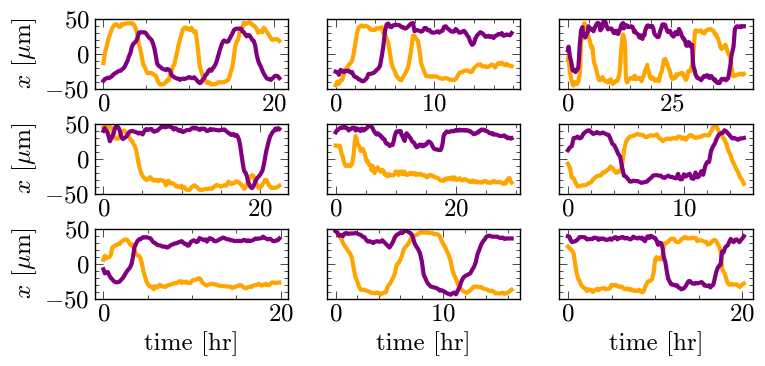

In [4]:
indx = np.random.randint(0, len(pair_stats), 9)
plot_trajectories(np.array(pair_stats, dtype=object)[indx])

4. Plot position joint probability

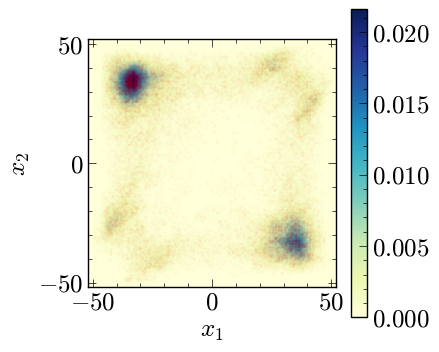

In [5]:
pos_joint_prob(pair_stats_df)

5. Stats across all cell pairs -- global bounds used to defin acceleration map bounding box

In [27]:
x_min = pair_stats_df.x.min() - 1
x_max = pair_stats_df.x.max() + 1
v_min = pair_stats_df.v.min() - 1
v_max = pair_stats_df.v.max() + 1
a_min = pair_stats_df.a.min()
a_max = pair_stats_df.a.max()

print(f"x: [{x_min:.3f}, {x_max:.3f}] mu")
print(f"v: [{v_min:.3f}, {v_max:.3f}] mu/hr")
print(f"a: [{a_min:.3f}, {a_max:.3f}] mu/hr^2")

nbins = 40
dx = (x_max - x_min) / nbins
dv = (v_max - v_min) / nbins


x: [-52.053, 51.433] mu
v: [-253.721, 385.912] mu/hr
a: [-2216.160, 2332.800] mu/hr^2


6. Acceleration map 

   $F(x, v)=\langle \dot{v_i}\ |\ x_i, v_i;\ |\Delta x_{ij}| > \ell \rangle$
      - average over the two cells
      - for each cell, focus on single cell part and average its acceleration

/tmp/ipykernel_491/256134594.py:5: RuntimeWarning: Mean of empty slice
  F = np.nanmean(Fs, axis=0)


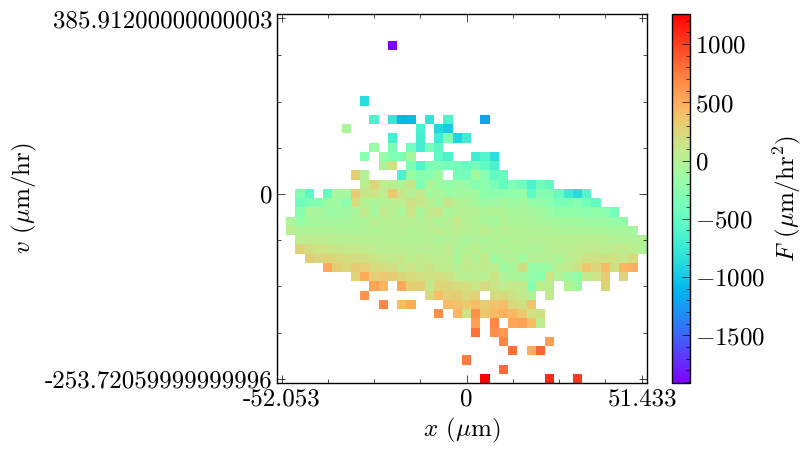

In [28]:
Fs = []
for id, df_id in pair_stats_df.query("single == True and v < @v_max and v > @v_min and x < @x_max and x > @x_min").groupby("id"):
    Fs.append(map_one_pair(df_id, nbins, dx, x_min, dv, v_min))

F = np.nanmean(Fs, axis=0)

plt.imshow(
    F,
    origin="lower",
    # extent=[x_min, x_max, v_min, v_max],
    cmap="rainbow",
    interpolation="none",
)
cbar = plt.colorbar()
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
plt.xticks([0, nbins//2, nbins-1], [x_min, 0, x_max])
plt.yticks([0, nbins//2, nbins-1], [v_min, 0, v_max])
plt.show()

$G(\Delta x, \Delta v)=\langle \dot{v_i} -F(x_i, v_i)\ |\ \Delta x_{ij}, \Delta v_{ij};\ |\Delta x_{ij}| < \ell \rangle$

1. Consider the entire $(x, v, a)$ time series where cells are interacting.
2. Split into two tables, one for each cell.
3. For cell $i$, compute
   - $\Delta x_i = x_i - x_j$
   - $\Delta v_i = v_i - v_j$
   - $G_i = a_i - F[x_i, v_i]$
4. Repeat step 3 for cell $j$.
5. Average two results, where the bracket average is over the two cells.

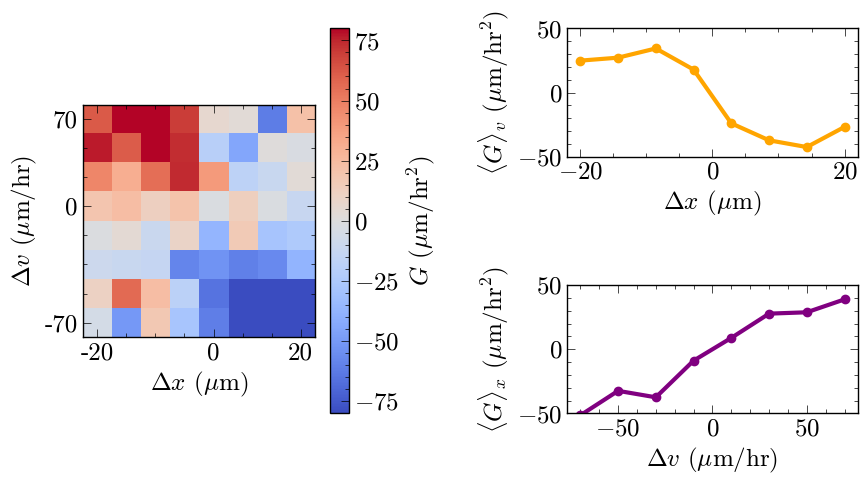

In [130]:
df_0 = pair_stats_df.query("single == False and id == 'c0'").reset_index(drop=True)
df_1 = pair_stats_df.query("single == False and id == 'c1'").reset_index(drop=True)

# display(df_0, df_1)

dfs = [df_0, df_1]
Gs = []

Dx_min = -20
Dx_max = 20
Dv_min = -70
Dv_max = 70

nbins = 8
Dx = (Dx_max - Dx_min) / nbins
Dv = (Dv_max - Dv_min) / nbins

for i in [0, 1]:

    j = 1 if i == 0 else 0
    df_i = dfs[i]
    df_j = dfs[j]

    delta_x = df_i.x - df_j.x
    delta_v = df_i.v - df_j.v
    df_i["delta_x"] = delta_x
    df_i["delta_v"] = delta_v

    df_i = (
        df_i.query(
            "delta_x < @Dx_max and delta_x > @Dx_min and delta_v < @Dv_max and delta_v > @Dv_min"
        )
        .copy()
        .reset_index(drop=True)
    )

    # set delta space indices
    df_i["delta_x_bin"] = np.floor((df_i["delta_x"].values - Dx_min) / Dx).astype("int")
    df_i["delta_v_bin"] = np.floor((df_i["delta_v"].values - Dv_min) / Dv).astype("int")

    # set single-cell space indices
    df_i["x_bin"] = np.floor((df_i.x.values - x_min) / dx).astype("int")
    df_i["v_bin"] = np.floor((df_i.v.values - v_min) / dv).astype("int")
    df_i["F"] = [F[int(i), int(j)] for i, j in zip(df_i["v_bin"], df_i["x_bin"])]

    df_i["G"] = df_i.a - df_i.F
    # display(df_i)
    # print(df_i["delta_v_bin"].unique(), df_i["delta_x_bin"].unique())

    # make map
    G = np.empty((nbins, nbins))
    for (j, i), df in df_i.groupby(["delta_x_bin", "delta_v_bin"]):
        G[i, j] = df.G.mean()

    Gs.append(G)

G = np.nanmean(Gs, axis=0)

fig = plt.figure(figsize=(10, 5))
ax_img = plt.subplot2grid(shape=(2, 4), loc=(0, 0), rowspan=2, colspan=2, fig=fig)
ax_x = plt.subplot2grid(shape=(2, 4), loc=(0, 2), rowspan=1, colspan=2, fig=fig)
ax_v = plt.subplot2grid(shape=(2, 4), loc=(1, 2), rowspan=1, colspan=2, fig=fig)

# G
img = ax_img.imshow(
    G, origin="lower", cmap="coolwarm", interpolation="none", vmin=-80, vmax=80
)
cbar = plt.colorbar(img, ax=ax_img)
ax_img.set_xlabel(r"$\Delta x$ ($\mu$m)")
ax_img.set_ylabel(r"$\Delta v$ ($\mu$m/hr)")
cbar.set_label(r"$G$ ($\mu$m/hr$^2$)")
ax_img.set_xticks([0, nbins // 2, nbins - 1], [Dx_min, 0, Dx_max])
ax_img.set_yticks([0, nbins // 2, nbins - 1], [Dv_min, 0, Dv_max])

# G slices
ax_x.plot(
    np.linspace(Dx_min, Dx_max, nbins), np.mean(G, axis=0), "-o", color="orange", lw=3
)
ax_x.set_xlabel(r"$\Delta x$ ($\mu$m)")
ax_x.set_ylabel(r"$\langle G \rangle_{v}$ ($\mu$m/hr$^2$)")
ax_x.set_ylim([-50, 50])

ax_v.plot(
    np.linspace(Dv_min, Dv_max, nbins), np.mean(G, axis=1), "-o", color="purple", lw=3
)
ax_v.set_xlabel(r"$\Delta v$ ($\mu$m/hr)")
ax_v.set_ylabel(r"$\langle G \rangle_{x}$ ($\mu$m/hr$^2$)")
ax_v.set_ylim([-50, 50])

plt.subplots_adjust(wspace=4, hspace=1)
